In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
from sklearn.preprocessing import LabelEncoder

import tensorflow as tf
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import backend as K

In [2]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import MaxPool2D
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from tensorflow.keras.utils import to_categorical

In [3]:
gpus = tf.config.experimental.list_physical_devices('GPU')
tf.config.experimental.set_virtual_device_configuration(gpus[0], [
    tf.config.experimental.VirtualDeviceConfiguration(memory_limit=2000)])

In [4]:
INIT_LR = 1e-3
EPOCHS = 50
BS = 128
optimizer = Adam(lr=INIT_LR)
num_classes = 10
modelOutput = 'data/model_nn.h5'

In [5]:
item_categories = pd.read_csv('data/item_categories.csv')
items = pd.read_csv('data/items.csv')
train = pd.read_csv('data/sales_train.csv')
shops = pd.read_csv('data/shops.csv')
test = pd.read_csv('data/test.csv')

          item_price
count   21807.000000
mean      823.890413
std      2784.195667
min         4.914856
25%       186.541323
50%       322.363636
75%       850.000000
max    307980.000000


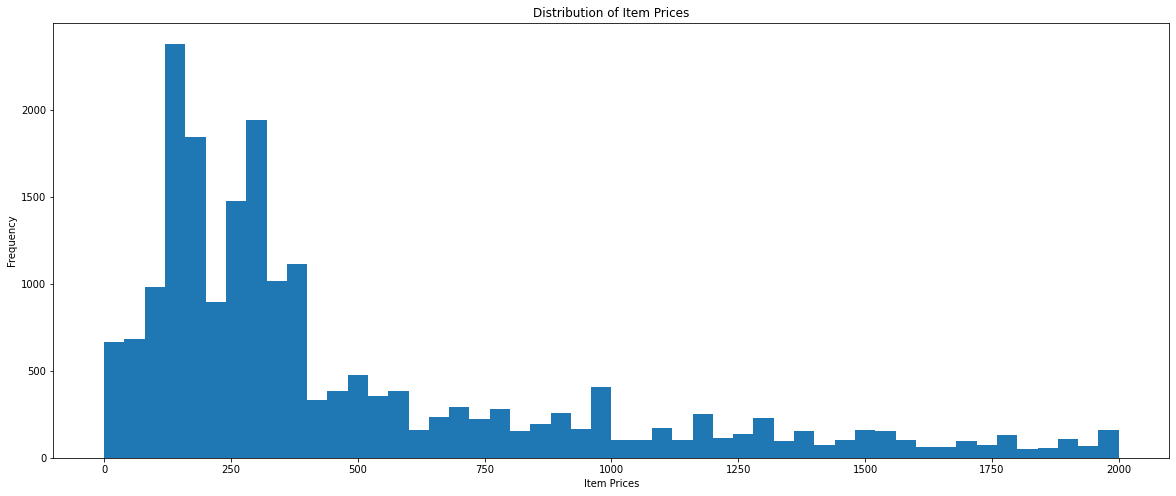

In [6]:
average_price = pd.DataFrame(train['item_price'].groupby(train['item_id']).mean())
print(average_price.describe())
plt.figure(figsize=(20,8))
plt.hist(average_price['item_price'],bins = 50,range=(0,2000))
plt.xlabel('Item Prices')
plt.ylabel('Frequency')
plt.title('Distribution of Item Prices')
plt.show()

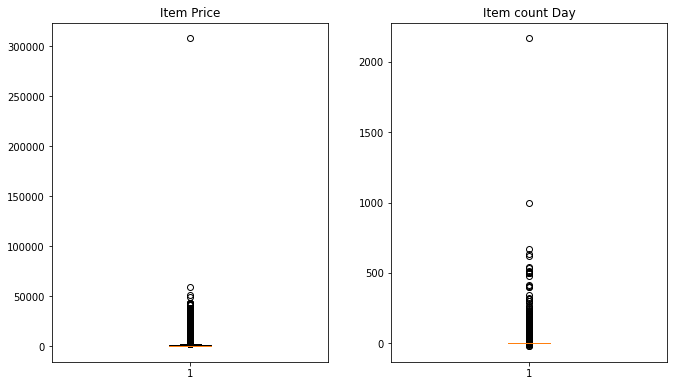

In [7]:
plt.figure(figsize=(10,6))
plt.subplot(121)
plt.boxplot(train['item_price'])
plt.title('Item Price')
plt.subplot(122)
plt.boxplot(train['item_cnt_day'])
plt.title('Item count Day')
plt.tight_layout(pad=3)
plt.show()

In [8]:
train = train[(train['item_price']<10000) & (train['item_cnt_day']<1001)]

In [9]:
shops['shop_name'].groupby(shops.shop_id).value_counts()

shop_id  shop_name                                      
0        !Якутск Орджоникидзе, 56 фран                      1
1        !Якутск ТЦ "Центральный" фран                      1
2        Адыгея ТЦ "Мега"                                   1
3        Балашиха ТРК "Октябрь-Киномир"                     1
4        Волжский ТЦ "Волга Молл"                           1
5        Вологда ТРЦ "Мармелад"                             1
6        Воронеж (Плехановская, 13)                         1
7        Воронеж ТРЦ "Максимир"                             1
8        Воронеж ТРЦ Сити-Парк "Град"                       1
9        Выездная Торговля                                  1
10       Жуковский ул. Чкалова 39м?                         1
11       Жуковский ул. Чкалова 39м²                         1
12       Интернет-магазин ЧС                                1
13       Казань ТЦ "Бехетле"                                1
14       Казань ТЦ "ПаркХаус" II                            1
15       Калу

In [10]:
train.loc[train.shop_id == 0,'shop_id']=57
test.loc[test.shop_id == 0,'shop_id']=57
train.loc[train.shop_id == 1,'shop_id']=58
test.loc[test.shop_id == 1,'shop_id']=58
train.loc[train.shop_id == 10,'shop_id']=11
test.loc[test.shop_id == 10,'shop_id']=11

In [11]:
ic = item_categories

ic['split'] = ic['item_category_name'].str.split('-')
ic['type'] = ic['split'].map(lambda x:x[0].strip())
ic['type_code'] = LabelEncoder().fit_transform(ic['type'])
ic['subtype'] = ic['split'].map(lambda x: x[1].strip() if len(x)>1 else x[0].strip())
ic['subtype_code'] = LabelEncoder().fit_transform(ic['subtype'])
ic = ic[['item_category_id','type_code','subtype_code']]
ic.head()

,item_category_id,type_code,subtype_code
0,0,0,29
1,1,1,9
2,2,1,10
3,3,1,11
4,4,1,13


In [12]:
items.drop(['item_name'],axis=1,inplace=True)
items.head()

,item_id,item_category_id
0,0,40
1,1,76
2,2,40
3,3,40
4,4,40


In [13]:
train[(train['shop_id'] == 5) & (train['item_id']==5320)]

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day


In [14]:
import itertools

In [15]:
train_match = []

for i in range(34):
    sales = train[train.date_block_num==i]
    train_match.append(np.array(list(itertools.product([i],sales.shop_id.unique(),
                                        sales.item_id.unique())),dtype='int16'))

train_match[:5]

[array([[    0,    59, 22154],
        [    0,    59,  2552],
        [    0,    59,  2554],
        ...,
        [    0,    45,   628],
        [    0,    45,   631],
        [    0,    45,   621]], dtype=int16),
 array([[    1,    50,  3880],
        [    1,    50,  4128],
        [    1,    50,  4124],
        ...,
        [    1,    28, 12870],
        [    1,    28, 12885],
        [    1,    28, 12791]], dtype=int16),
 array([[    2,     5, 20175],
        [    2,     5, 20083],
        [    2,     5,    31],
        ...,
        [    2,     4, 12388],
        [    2,     4, 12340],
        [    2,     4, 10649]], dtype=int16),
 array([[    3,    25,  8092],
        [    3,    25,  7850],
        [    3,    25,  8051],
        ...,
        [    3,    41, 14063],
        [    3,    41, 20690],
        [    3,    41, 19235]], dtype=int16),
 array([[    4,    59, 22114],
        [    4,    59, 20239],
        [    4,    59, 20238],
        ...,
        [    4,     6,  1924],
       

In [16]:
train_match = pd.DataFrame(np.vstack(train_match),columns =['date_block_num','shop_id','item_id'])
train_match.sort_values(by = ['date_block_num','shop_id','item_id'],inplace=True)
train_match.head()

,date_block_num,shop_id,item_id
114345,0,2,19
116573,0,2,27
120030,0,2,28
117731,0,2,29
114037,0,2,32


In [17]:
grouped = train.groupby(['date_block_num','shop_id','item_id']).agg({'item_cnt_day':['sum']})
grouped.columns = ['item_cnt_month']
grouped.reset_index(inplace = True)
train_match = pd.merge(train_match,grouped,on=['date_block_num','shop_id','item_id'],how='left')
train_match.head()

,date_block_num,shop_id,item_id,item_cnt_month
0,0,2,19,NaN
1,0,2,27,1.0
2,0,2,28,NaN
3,0,2,29,NaN
4,0,2,32,NaN


In [18]:
train_match['item_cnt_month'] = (train_match['item_cnt_month']
                                 .fillna(0).clip(0,20).astype(np.float16))
train_match.head()

,date_block_num,shop_id,item_id,item_cnt_month
0,0,2,19,0.0
1,0,2,27,1.0
2,0,2,28,0.0
3,0,2,29,0.0
4,0,2,32,0.0


In [19]:
test['date_block_num'] = 34
train_match = pd.concat([train_match,test],ignore_index=True,
                        sort = False,keys = ['date_block_num','shop_id','item_id'])
train_match.fillna(0,inplace=True)
train_match.tail()

,date_block_num,shop_id,item_id,item_cnt_month,ID
11084746,34,45,18454,0.0,214195.0
11084747,34,45,16188,0.0,214196.0
11084748,34,45,15757,0.0,214197.0
11084749,34,45,19648,0.0,214198.0
11084750,34,45,969,0.0,214199.0


In [20]:
train_match = pd.merge(train_match, items, on=['item_id'], how = 'left')
train_match = pd.merge(train_match, ic, on=['item_category_id'], how = 'left')
train_match.head()

,date_block_num,shop_id,item_id,item_cnt_month,ID,item_category_id,type_code,subtype_code
0,0,2,19,0.0,0.0,40,11,4
1,0,2,27,1.0,0.0,19,5,10
2,0,2,28,0.0,0.0,30,8,55
3,0,2,29,0.0,0.0,23,5,16
4,0,2,32,0.0,0.0,40,11,4


In [21]:
def create_lag_feature(df,lags,col):
    tmp = df[['date_block_num','shop_id','item_id',col]]
    for lag in lags:
        shifted = tmp.copy()
        shifted.columns = ['date_block_num','shop_id','item_id',col+'_lag_'+str(lag)]
        ##col value is the timestamp 'lag' (months/date_block_num) before 
        shifted['date_block_num'] += lag
        df = pd.merge(df, shifted, on=['date_block_num','shop_id','item_id'],how = 'left')
    
    return df

In [22]:
train_match = create_lag_feature(train_match,[1,2,3,6,12],'item_cnt_month')
train_match.head()

,date_block_num,shop_id,item_id,item_cnt_month,ID,item_category_id,type_code,subtype_code,item_cnt_month_lag_1,item_cnt_month_lag_2,item_cnt_month_lag_3,item_cnt_month_lag_6,item_cnt_month_lag_12
0,0,2,19,0.0,0.0,40,11,4,NaN,NaN,NaN,NaN,NaN
1,0,2,27,1.0,0.0,19,5,10,NaN,NaN,NaN,NaN,NaN
2,0,2,28,0.0,0.0,30,8,55,NaN,NaN,NaN,NaN,NaN
3,0,2,29,0.0,0.0,23,5,16,NaN,NaN,NaN,NaN,NaN
4,0,2,32,0.0,0.0,40,11,4,NaN,NaN,NaN,NaN,NaN


In [23]:
grouped2 = train_match.groupby(['date_block_num']).agg({'item_cnt_month':['mean']})
grouped2.columns = ['avg_item_cnt_month']
grouped2.reset_index(inplace = True)
grouped2.head()

,date_block_num,avg_item_cnt_month
0,0,0.346924
1,1,0.324219
2,2,0.355957
3,3,0.275635
4,4,0.265625


In [24]:
train_match = pd.merge(train_match, grouped2, on=['date_block_num'], how='left')
train_match['avg_item_cnt_month'] = train_match['avg_item_cnt_month'].astype('float16')
train_match = create_lag_feature(train_match, [1],'avg_item_cnt_month')
train_match.drop(['avg_item_cnt_month'],axis =1, inplace = True)
train_match.sample(5)

,date_block_num,shop_id,item_id,item_cnt_month,ID,item_category_id,type_code,subtype_code,item_cnt_month_lag_1,item_cnt_month_lag_2,item_cnt_month_lag_3,item_cnt_month_lag_6,item_cnt_month_lag_12,avg_item_cnt_month_lag_1
6734197,18,50,1282,0.0,0.0,55,13,2,1.0,0.0,NaN,NaN,NaN,0.272217
6735482,18,50,5713,0.0,0.0,75,15,30,NaN,NaN,NaN,NaN,NaN,NaN
7753642,21,59,20415,0.0,0.0,72,14,59,NaN,NaN,NaN,NaN,NaN,NaN
5846949,16,6,11383,2.0,0.0,63,14,41,NaN,NaN,NaN,0.0,NaN,NaN
5081566,13,51,2068,0.0,0.0,30,8,55,0.0,0.0,0.0,0.0,0.0,0.309570


In [25]:
grouped3 = train_match.groupby(['date_block_num','item_id']).agg({'item_cnt_month':['mean']})
grouped3.columns = ['item_avg_item_cnt_month']
grouped3.reset_index(inplace = True)
train_match = pd.merge(train_match, grouped3, on=['date_block_num','item_id'], how ='left')
train_match['item_avg_item_cnt_month'] = train_match['item_avg_item_cnt_month'].astype('float16')
train_match = create_lag_feature(train_match, [1,2,3,6,12], 'item_avg_item_cnt_month')
train_match.drop(['item_avg_item_cnt_month'], axis =1, inplace =True)
train_match.sample(5)

,date_block_num,shop_id,item_id,item_cnt_month,ID,item_category_id,type_code,subtype_code,item_cnt_month_lag_1,item_cnt_month_lag_2,item_cnt_month_lag_3,item_cnt_month_lag_6,item_cnt_month_lag_12,avg_item_cnt_month_lag_1,item_avg_item_cnt_month_lag_1,item_avg_item_cnt_month_lag_2,item_avg_item_cnt_month_lag_3,item_avg_item_cnt_month_lag_6,item_avg_item_cnt_month_lag_12
7654551,21,44,5066,0.0,0.0,55,13,2,0.0,0.0,1.0,2.0,NaN,0.270020,0.140015,0.039215,0.140015,0.306152,NaN
10859817,33,58,139,0.0,0.0,45,12,23,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2223426,5,56,10503,0.0,0.0,40,11,4,0.0,0.0,0.0,NaN,NaN,0.265625,0.044434,0.021744,0.043488,NaN,NaN
4679010,12,38,11966,0.0,0.0,40,11,4,0.0,2.0,5.0,NaN,NaN,0.407471,2.826172,5.042969,7.824219,NaN,NaN
2208430,5,54,14776,0.0,0.0,40,11,4,1.0,1.0,3.0,NaN,NaN,0.265625,0.555664,1.043945,1.891602,NaN,NaN


In [26]:
grouped4 = train_match.groupby(['date_block_num','shop_id']).agg({'item_cnt_month':['mean']})
grouped4.columns = ['shop_avg_item_cnt_month']
grouped4.reset_index(inplace = True)
train_match = pd.merge(train_match, grouped4, on=['date_block_num','shop_id'], how ='left')
train_match['shop_avg_item_cnt_month'] = train_match['shop_avg_item_cnt_month'].astype('float16')
train_match = create_lag_feature(train_match, [1,2,3,6,12], 'shop_avg_item_cnt_month')
train_match.drop(['shop_avg_item_cnt_month'], axis =1, inplace =True)
train_match.sample(5)

,date_block_num,shop_id,item_id,item_cnt_month,ID,item_category_id,type_code,subtype_code,item_cnt_month_lag_1,item_cnt_month_lag_2,...,item_avg_item_cnt_month_lag_1,item_avg_item_cnt_month_lag_2,item_avg_item_cnt_month_lag_3,item_avg_item_cnt_month_lag_6,item_avg_item_cnt_month_lag_12,shop_avg_item_cnt_month_lag_1,shop_avg_item_cnt_month_lag_2,shop_avg_item_cnt_month_lag_3,shop_avg_item_cnt_month_lag_6,shop_avg_item_cnt_month_lag_12
1702899,4,35,11744,0.0,0.0,37,11,1,0.0,1.0,...,0.065247,0.152222,0.173950,NaN,NaN,0.220947,0.303467,0.267578,NaN,NaN
7291784,20,37,18258,0.0,0.0,55,13,2,0.0,0.0,...,0.078430,0.099976,0.020401,0.083313,0.133301,0.176758,0.136597,0.148071,0.154175,0.174316
7100493,19,56,9373,0.0,0.0,70,14,57,0.0,0.0,...,0.020004,0.040802,0.040802,0.021744,0.022217,0.336426,0.363037,0.283447,0.312256,0.394287
6081956,16,50,16710,0.0,0.0,37,11,1,1.0,NaN,...,1.082031,NaN,NaN,0.022217,NaN,0.296631,NaN,NaN,0.387939,NaN
346499,0,57,19728,0.0,0.0,40,11,4,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [27]:
grouped5 = train_match.groupby(['date_block_num','item_category_id']).agg({'item_cnt_month':['mean']})
grouped5.columns = ['ic_avg_item_cnt_month']
grouped5.reset_index(inplace = True)
train_match = pd.merge(train_match, grouped5, on=['date_block_num','item_category_id'], how ='left')
train_match['ic_avg_item_cnt_month'] = train_match['ic_avg_item_cnt_month'].astype('float16')
train_match = create_lag_feature(train_match, [1], 'ic_avg_item_cnt_month')
train_match.drop(['ic_avg_item_cnt_month'], axis =1, inplace =True)
train_match.sample(5)

,date_block_num,shop_id,item_id,item_cnt_month,ID,item_category_id,type_code,subtype_code,item_cnt_month_lag_1,item_cnt_month_lag_2,...,item_avg_item_cnt_month_lag_2,item_avg_item_cnt_month_lag_3,item_avg_item_cnt_month_lag_6,item_avg_item_cnt_month_lag_12,shop_avg_item_cnt_month_lag_1,shop_avg_item_cnt_month_lag_2,shop_avg_item_cnt_month_lag_3,shop_avg_item_cnt_month_lag_6,shop_avg_item_cnt_month_lag_12,ic_avg_item_cnt_month_lag_1
4594413,12,22,6774,0.0,0.0,19,5,10,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
813457,2,13,4562,0.0,0.0,59,13,40,0.0,NaN,...,NaN,NaN,NaN,NaN,0.122620,NaN,NaN,NaN,NaN,0.093079
8597283,24,42,16434,7.0,0.0,40,11,4,9.0,NaN,...,NaN,NaN,NaN,NaN,0.895020,NaN,NaN,NaN,NaN,0.338867
9839268,29,25,19299,0.0,0.0,49,12,39,NaN,0.0,...,0.021271,0.043488,0.020004,0.061218,NaN,0.878906,0.913086,1.53418,0.810059,NaN
6983367,19,37,20384,0.0,0.0,72,14,59,0.0,0.0,...,0.020401,0.142822,0.391357,0.888672,0.136597,0.148071,0.141357,0.14209,0.168823,0.227417


In [28]:
grouped6 = train_match.groupby(['date_block_num','type_code']).agg({'item_cnt_month':['mean']})
grouped6.columns = ['type_avg_item_cnt_month']
grouped6.reset_index(inplace = True)
train_match = pd.merge(train_match, grouped6, on=['date_block_num','type_code'], how ='left')
train_match['type_avg_item_cnt_month'] = train_match['type_avg_item_cnt_month'].astype('float16')
train_match = create_lag_feature(train_match, [1], 'type_avg_item_cnt_month')
train_match.drop(['type_avg_item_cnt_month'], axis =1, inplace =True)
train_match.sample(5)

,date_block_num,shop_id,item_id,item_cnt_month,ID,item_category_id,type_code,subtype_code,item_cnt_month_lag_1,item_cnt_month_lag_2,...,item_avg_item_cnt_month_lag_3,item_avg_item_cnt_month_lag_6,item_avg_item_cnt_month_lag_12,shop_avg_item_cnt_month_lag_1,shop_avg_item_cnt_month_lag_2,shop_avg_item_cnt_month_lag_3,shop_avg_item_cnt_month_lag_6,shop_avg_item_cnt_month_lag_12,ic_avg_item_cnt_month_lag_1,type_avg_item_cnt_month_lag_1
2707539,7,13,13791,0.0,0.0,37,11,1,0.0,0.0,...,0.044434,NaN,NaN,0.126587,0.155029,0.129272,NaN,NaN,0.224976,0.219360
9008146,26,5,15934,0.0,0.0,72,14,59,0.0,0.0,...,0.140015,NaN,NaN,0.177368,0.208252,0.292480,NaN,NaN,0.219360,0.304688
9879694,29,38,15114,0.0,0.0,67,14,52,0.0,0.0,...,0.108704,0.540039,0.020401,0.219238,0.193970,0.240234,0.371582,0.199097,0.120972,0.261963
8294168,23,44,6590,0.0,0.0,25,5,18,0.0,0.0,...,0.020004,NaN,0.043488,0.181885,0.175049,0.159668,NaN,0.247681,0.091553,0.693848
3245597,8,44,10356,0.0,0.0,41,11,35,0.0,0.0,...,0.130493,0.152222,NaN,0.196045,0.170166,0.183472,0.248047,NaN,0.183472,0.229004


In [29]:
grouped7 = train_match.groupby(['date_block_num','subtype_code']).agg({'item_cnt_month':['mean']})
grouped7.columns = ['subtype_avg_item_cnt_month']
grouped7.reset_index(inplace = True)
train_match = pd.merge(train_match, grouped7, on=['date_block_num','subtype_code'], how ='left')
train_match['subtype_avg_item_cnt_month'] = train_match['subtype_avg_item_cnt_month'].astype('float16')
train_match = create_lag_feature(train_match, [1], 'subtype_avg_item_cnt_month')
train_match.drop(['subtype_avg_item_cnt_month'], axis =1, inplace =True)
train_match.sample(5)

,date_block_num,shop_id,item_id,item_cnt_month,ID,item_category_id,type_code,subtype_code,item_cnt_month_lag_1,item_cnt_month_lag_2,...,item_avg_item_cnt_month_lag_6,item_avg_item_cnt_month_lag_12,shop_avg_item_cnt_month_lag_1,shop_avg_item_cnt_month_lag_2,shop_avg_item_cnt_month_lag_3,shop_avg_item_cnt_month_lag_6,shop_avg_item_cnt_month_lag_12,ic_avg_item_cnt_month_lag_1,type_avg_item_cnt_month_lag_1,subtype_avg_item_cnt_month_lag_1
333325,0,56,7139,0.0,0.0,23,5,16,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8609676,24,44,17104,1.0,0.0,40,11,4,1.0,4.0,...,NaN,NaN,0.236206,0.181885,NaN,NaN,NaN,0.338867,0.290771,0.338867
7370808,20,50,19406,0.0,0.0,28,8,32,0.0,0.0,...,0.229126,0.222168,0.243652,0.233032,0.249023,0.386719,0.395996,1.294922,0.580078,1.294922
4158488,11,13,19872,0.0,0.0,55,13,2,0.0,0.0,...,0.217407,NaN,0.123596,0.130859,0.133667,0.155029,NaN,0.223511,0.169678,0.223511
5394843,14,46,3734,7.0,0.0,23,5,16,11.0,14.0,...,19.437500,NaN,0.316406,0.348633,0.435059,0.310547,NaN,0.940918,0.806641,0.900879


In [30]:
grouped8 = train_match.groupby(['date_block_num','shop_id','item_category_id']).agg({'item_cnt_month':['mean']})
grouped8.columns = ['shop_ic_avg_item_cnt_month']
grouped8.reset_index(inplace = True)
train_match = pd.merge(train_match, grouped8, on=['date_block_num','shop_id','item_category_id'], how ='left')
train_match['shop_ic_avg_item_cnt_month'] = train_match['shop_ic_avg_item_cnt_month'].astype('float16')
train_match = create_lag_feature(train_match, [1], 'shop_ic_avg_item_cnt_month')
train_match.drop(['shop_ic_avg_item_cnt_month'], axis =1, inplace =True)
train_match.sample(5)

,date_block_num,shop_id,item_id,item_cnt_month,ID,item_category_id,type_code,subtype_code,item_cnt_month_lag_1,item_cnt_month_lag_2,...,item_avg_item_cnt_month_lag_12,shop_avg_item_cnt_month_lag_1,shop_avg_item_cnt_month_lag_2,shop_avg_item_cnt_month_lag_3,shop_avg_item_cnt_month_lag_6,shop_avg_item_cnt_month_lag_12,ic_avg_item_cnt_month_lag_1,type_avg_item_cnt_month_lag_1,subtype_avg_item_cnt_month_lag_1,shop_ic_avg_item_cnt_month_lag_1
3579439,9,38,9675,0.0,0.0,40,11,4,0.0,NaN,...,NaN,0.179199,NaN,0.163330,0.167725,NaN,0.227539,0.213501,0.227539,0.068237
9737311,28,57,6435,0.0,0.0,31,8,61,NaN,NaN,...,0.408203,NaN,NaN,0.559082,0.518066,0.545410,NaN,NaN,NaN,NaN
4832788,13,4,1939,0.0,0.0,28,8,32,0.0,0.0,...,NaN,0.177246,0.241333,0.164185,0.210083,NaN,0.982422,0.665527,0.982422,1.037109
4621321,12,26,18929,0.0,0.0,40,11,4,0.0,NaN,...,0.688965,0.360596,NaN,0.258301,0.233154,0.286133,0.291504,0.270020,0.291504,0.251221
2920454,7,50,5466,0.0,0.0,56,13,3,NaN,0.0,...,NaN,NaN,0.390381,0.334473,0.368652,NaN,NaN,NaN,NaN,NaN


In [31]:
grouped9 = train_match.groupby(['date_block_num','shop_id','type_code']).agg({'item_cnt_month':['mean']})
grouped9.columns = ['shop_type_avg_item_cnt_month']
grouped9.reset_index(inplace = True)
train_match = pd.merge(train_match, grouped9, on=['date_block_num','shop_id','type_code'], how ='left')
train_match['shop_type_avg_item_cnt_month'] = train_match['shop_type_avg_item_cnt_month'].astype('float16')
train_match = create_lag_feature(train_match, [1], 'shop_type_avg_item_cnt_month')
train_match.drop(['shop_type_avg_item_cnt_month'], axis =1, inplace =True)
train_match.sample(5)

,date_block_num,shop_id,item_id,item_cnt_month,ID,item_category_id,type_code,subtype_code,item_cnt_month_lag_1,item_cnt_month_lag_2,...,shop_avg_item_cnt_month_lag_1,shop_avg_item_cnt_month_lag_2,shop_avg_item_cnt_month_lag_3,shop_avg_item_cnt_month_lag_6,shop_avg_item_cnt_month_lag_12,ic_avg_item_cnt_month_lag_1,type_avg_item_cnt_month_lag_1,subtype_avg_item_cnt_month_lag_1,shop_ic_avg_item_cnt_month_lag_1,shop_type_avg_item_cnt_month_lag_1
2721802,7,15,9315,0.0,0.0,43,12,21,0.0,0.0,...,0.296875,0.265137,0.223877,0.318604,NaN,0.095520,0.110657,0.095520,0.000000,0.004444
897377,2,25,8179,0.0,0.0,55,13,2,0.0,0.0,...,0.898438,0.949219,NaN,NaN,NaN,0.188599,0.152832,0.188599,0.544922,0.539551
5727443,15,46,16409,0.0,0.0,40,11,4,NaN,0.0,...,NaN,0.316406,0.348633,0.293213,0.261475,NaN,NaN,NaN,NaN,NaN
4306382,11,37,9652,0.0,0.0,41,11,35,0.0,0.0,...,0.144043,0.131958,NaN,NaN,NaN,0.163330,0.221436,0.163330,0.080261,0.065857
2647530,7,3,2720,0.0,0.0,23,5,16,0.0,0.0,...,0.081787,0.088257,0.084534,0.097717,NaN,0.509766,0.566406,0.500977,0.228394,0.278564


In [32]:
grouped10 = train.groupby(['item_id']).agg({'item_price':['mean']})
grouped10.columns = ['item_avg_item_price']
grouped10.reset_index(inplace = True)
train_match = pd.merge(train_match, grouped10, on=['item_id'], how='left')
train_match['item_avg_item_price'] = train_match['item_avg_item_price'].astype('float16')

grouped11 = train.groupby(['date_block_num','item_id']).agg({'item_price':['mean']})
grouped11.columns = ['item_avg_item_price_month']
grouped11.reset_index(inplace = True)
train_match = pd.merge(train_match, grouped11, on=['date_block_num','item_id'], how='left')
train_match['item_avg_item_price_month'] = train_match['item_avg_item_price_month'].astype('float16')

all_lags = [1,2,3,4,5,6]
train_match = create_lag_feature(train_match,all_lags,'item_avg_item_price_month')

In [33]:
for l in all_lags:
    train_match['delta_price_lag_'+str(l)]= (train_match['item_avg_item_price_month_lag_'+str(l)] - train_match['item_avg_item_price'])/train_match['item_avg_item_price']

def valid_trend(row):
    for l in all_lags:
        if row['delta_price_lag_'+str(l)]:
            return row['delta_price_lag_'+str(l)]
    return 0

train_match['delta_price_lag'] = train_match.apply(valid_trend, axis=1)
train_match['delta_price_lag'] = train_match['delta_price_lag'].astype('float16')
train_match['delta_price_lag'].fillna(0, inplace =True)

to_drop = ['item_avg_item_price','item_avg_item_price_month']
for l in all_lags:
    to_drop += ['item_avg_item_price_month_lag_'+str(l)]
    to_drop += ['delta_price_lag_'+str(l)]
    
train_match.drop(to_drop, axis=1, inplace=True)
train_match.sample(5)

,date_block_num,shop_id,item_id,item_cnt_month,ID,item_category_id,type_code,subtype_code,item_cnt_month_lag_1,item_cnt_month_lag_2,...,shop_avg_item_cnt_month_lag_2,shop_avg_item_cnt_month_lag_3,shop_avg_item_cnt_month_lag_6,shop_avg_item_cnt_month_lag_12,ic_avg_item_cnt_month_lag_1,type_avg_item_cnt_month_lag_1,subtype_avg_item_cnt_month_lag_1,shop_ic_avg_item_cnt_month_lag_1,shop_type_avg_item_cnt_month_lag_1,delta_price_lag
474463,1,18,14331,0.0,0.0,37,11,1,0.0,NaN,...,NaN,NaN,NaN,NaN,0.196045,0.271729,0.209839,0.237427,0.165039,0.532227
10956556,34,16,7746,0.0,86005.0,31,8,61,0.0,0.0,...,0.183716,0.230957,NaN,0.244995,0.077515,0.328857,0.090820,0.000000,0.276855,0.068787
9132326,26,35,5037,3.0,0.0,19,5,10,1.0,2.0,...,0.300293,0.464844,0.279053,NaN,0.497559,0.583984,0.482910,0.502930,0.707520,0.349365
7746700,21,58,18322,3.0,0.0,55,13,2,1.0,4.0,...,0.409912,0.326416,0.325928,NaN,0.196533,0.149170,0.196533,0.246826,0.162476,-0.026382
8838406,25,31,12191,0.0,0.0,31,8,61,0.0,0.0,...,1.794922,1.246094,1.129883,1.166016,0.080811,0.435059,0.084045,0.000000,1.317383,0.064026


In [34]:
train_match['month'] = (train_match['date_block_num']%12)+1
train_match.sample(5)

,date_block_num,shop_id,item_id,item_cnt_month,ID,item_category_id,type_code,subtype_code,item_cnt_month_lag_1,item_cnt_month_lag_2,...,shop_avg_item_cnt_month_lag_3,shop_avg_item_cnt_month_lag_6,shop_avg_item_cnt_month_lag_12,ic_avg_item_cnt_month_lag_1,type_avg_item_cnt_month_lag_1,subtype_avg_item_cnt_month_lag_1,shop_ic_avg_item_cnt_month_lag_1,shop_type_avg_item_cnt_month_lag_1,delta_price_lag,month
4049361,10,55,17781,0.0,0.0,37,11,1,0.0,0.0,...,0.083252,NaN,NaN,0.170776,0.209961,0.169189,0.000000,0.00000,0.115662,11
8367156,23,55,9304,0.0,0.0,43,12,21,NaN,NaN,...,0.285889,0.184692,0.133667,NaN,NaN,NaN,NaN,NaN,0.000000,12
9561340,28,12,17572,0.0,0.0,40,11,4,0.0,0.0,...,0.233276,0.273438,0.163208,0.226562,0.205566,0.226562,0.058533,0.13208,-0.263184,5
45562,0,8,14222,0.0,0.0,57,13,8,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,1
6513358,18,11,12341,0.0,0.0,40,11,4,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,7


In [35]:
sale_record = {}
train_match['last_item_sale'] = -1
train_match['last_item_sale'] = train_match['last_item_sale'].astype('int8')
for idx,row in train_match.iterrows():
    key = row.item_id
    if key not in sale_record.keys():
        if row.item_cnt_month != 0:
            sale_record[key] = row.date_block_num
            
    else:
        last_date_block_num = sale_record[key]
        if row.date_block_num > last_date_block_num:
            train_match.at[idx,'last_item_sale'] = row.date_block_num - last_date_block_num
            sale_record[key] = row.date_block_num
            
train_match.sample(5)

,date_block_num,shop_id,item_id,item_cnt_month,ID,item_category_id,type_code,subtype_code,item_cnt_month_lag_1,item_cnt_month_lag_2,...,shop_avg_item_cnt_month_lag_6,shop_avg_item_cnt_month_lag_12,ic_avg_item_cnt_month_lag_1,type_avg_item_cnt_month_lag_1,subtype_avg_item_cnt_month_lag_1,shop_ic_avg_item_cnt_month_lag_1,shop_type_avg_item_cnt_month_lag_1,delta_price_lag,month,last_item_sale
8228903,23,33,7951,1.0,0.0,6,1,16,0.0,0.0,...,NaN,NaN,0.569336,0.518555,0.634277,0.238037,0.309326,-0.049469,12,-1
9606904,28,25,10726,0.0,0.0,40,11,4,0.0,0.0,...,NaN,NaN,0.226562,0.205566,0.226562,0.956055,0.879395,0.019806,5,-1
3885074,10,27,9911,0.0,0.0,40,11,4,NaN,0.0,...,0.405762,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,11,-1
467314,1,16,17155,0.0,0.0,37,11,1,0.0,NaN,...,NaN,NaN,0.196045,0.271729,0.209839,0.162231,0.255615,-0.061890,2,-1
6334218,17,39,13549,0.0,0.0,69,14,56,0.0,NaN,...,NaN,NaN,0.168823,0.267334,0.168823,0.037506,0.142822,-0.124023,6,-1


In [36]:
train_match = train_match[train_match['date_block_num']>11]

In [37]:
def fillna_lag(df):
    for col in df.columns:
        if '_lag_' in col and df[col].isnull().any():
            if 'item_cnt' in col:
                df[col].fillna(0, inplace = True)
                
    return df

train_match = fillna_lag(train_match)

In [38]:
train_match.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6612902 entries, 4471849 to 11084750
Data columns (total 32 columns):
 #   Column                              Dtype  
---  ------                              -----  
 0   date_block_num                      int64  
 1   shop_id                             int64  
 2   item_id                             int64  
 3   item_cnt_month                      float16
 4   ID                                  float64
 5   item_category_id                    int64  
 6   type_code                           int32  
 7   subtype_code                        int32  
 8   item_cnt_month_lag_1                float16
 9   item_cnt_month_lag_2                float16
 10  item_cnt_month_lag_3                float16
 11  item_cnt_month_lag_6                float16
 12  item_cnt_month_lag_12               float16
 13  avg_item_cnt_month_lag_1            float16
 14  item_avg_item_cnt_month_lag_1       float16
 15  item_avg_item_cnt_month_lag_2       float1

In [41]:
from pandas import to_pickle

train_match.to_pickle('training.pkl')

In [45]:
del items
del shops
del ic
del train
del grouped
del grouped2
del grouped3
del grouped4
del grouped5
del grouped6
del grouped7
del grouped8
del grouped9
del grouped10
del grouped11

gc.collect()

NameError: name 'gc' is not defined

In [ ]:
training = pd.read_pickle('training.pkl')

In [ ]:
train_x = training[training.date_block_num<33].drop(['item_cnt_month'],axis=1)
train_y = training[training.date_block_num<33]['item_cnt_month']
valid_x = training[training.date_block_num==33].drop(['item_cnt_month'],axis=1)
valid_y = training[training.date_block_num==33]['item_cnt_month']
test_x = training[training.date_block_num==34].drop(['item_cnt_month'],axis=1)